# Der mehrdimensionale Kalman-Filter, Teil 1 Grundlagen
1.6.2020, S. Mack

In [1]:
# display plots inside this notebook
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

Die wichtigsten Erkenntnisse des voran gegangenen Jupyter-Notebooks zu den mehrdimensionalen Gaußverteilungen waren:
* Aus der skalaren Zufallsvariable und dem skalaren Erwartungswert werden beim Übergang von der eindimensionalen auf die mehrdimensionale Gaußverteilung Vektoren. Der Vektor $\boldsymbol\mu$ des Erwartungswerts besitzt für jede Zufallsvariable $i$ im entsprechenden Element den dazugehörigen Erwartungswert $\mu_i$.
* Aus der skalaren Standardabweichung wird im n-dimensionalen Fall eine $n \times n$-Matrix, die sogenannte Kovarianzmatrix $\mathbf\Sigma$. In deren Diagonalelementen $\Sigma_{ii}$ stecken die Varianzen der einzelnen Zufallsvariablen $i$. Außerhalb der Diagonalen befinden sich in den Elementen $\Sigma_{ij}$ die Kovarianzen, also das Korrelationsausmaß zwischen den beiden Zufallsvariablen $X_i$ und $X_j$.
* Beim Kalman-Filter sind die Zustandsgrößen die Zufallsvariablen. Auch sie werden zu einem Vektor, dem Zustandsvektor, zusammengefasst.
* Der Korrekturschritt ist wie im eindimensionalen Fall eine Multiplikation der beiden jetzt mehrdimensionalen Gaußverteilungen von Vorhersage und Messung. Die Mathematik dazu ändert sich nicht wesentlich.
* Die Korrelation zweier Zustandsgrößen führt dazu, dass dieser Korrekturschritt einen erheblich genaueren Schätzwert liefert als wären diese unkorreliert.
* Selbst wenn eine Zustandsgröße nicht gemessen wird, kann ihr Wert aufgrund der Korrelation genau geschätzt werden. Die Funktion des Kalman-Filters ist in diesem Fall primär gar nicht das Filtern der Messdaten sondern das Schätzen eines Paramters des physikalischen Modells, welcher oft gar nicht mit Sensoren erfasst werden kann.  

Im mehrdimensionalen Kalman-Filter **spielt die Korrelation zweier Zustandsgrößen** die zentrale Rolle.  

Dieses Jupyter-Notebook behandelt nur eine Unterklasse mehrdimensionaler Kalman-Filter: Filter mit einem physikalischen Modell, welches auf den newtonschen Bewegungsgleichungen beruht. 
Hierfür wird aber die allgemeine Form eines Kalman-Filters verwendet, so dass sich an den hier vorgestellen Algorithmen und an der Mathematik nichts wesentlich ändert, falls ein Kalman-Filter z.B. für die Ladezustand einer Batterie verwendet werden soll. Wenn dann auch noch die dem physikalischen Modell zugrunde liegenden Differentialgleichungen die selbe Struktur haben, dann kann der nachfolgend entwickelte Kalman-Filter sogar 1:1 darauf übertragen werden. Beispielsweise wird aus "Abstand" dann die Zustandsgröße "Ladung" und aus "Abstandsänderung" die Zustandsgröße "Strom".

In diesem Sinne werden im nächsten Kapitel zuerst einmal die newtonschen Bewegungsgleichungen wiederholt:

 ## Die newtonschen Bewegungsgleichungen

Die einfachste newtonsche Bewegungsgleichung berechnet bei bekannter Geschwindigkeit $v$ die Position $x$ in Abhängigkeit von der verstrichenen Zeit $t$:

$$x(t) = vt + x_0$$

Beispielsweise startet ein Fahrzeug an der Position $x_0 = 13 m$, besitzt eine konstante Geschwindigkeit $v = 10 m/s$ und fährt $t = 12 s$ lang. Am Ende dieser Zeit erreicht es somit die Position $ 133 m = 10 m/s\cdot 12 s + 13 m$ .

In einer etwas komplexeren Bewegungsgleichung besitzt das Fahrzeug zusätzlich eine Beschleunigung $a$. Dann ist nicht nur die Position $x$ sondern auch die (momentane) Geschwindigkeit $v$ von der verstrichenen Zeit $t$ abhängig:

$$x(t) = \int_0^t v(t)\, dt + v_0t + x_0 = \frac{1}{2}at^2 + v_0t + x_0$$

Beide Bewegungsgleichungen sind Lösungen des sogenannten zweiten newtonschen Gesetzes $F = m \cdot a$. Der Fall $a=0$ ist streng genommen das erste newtonsche Gesetz: "Wirkt auf einen Körper keine Kraft, so ist seine Geschwindigkeit zeitlich konstant". Somit gilt mit $v(t) = v = const.$:

$$\begin{aligned} v &= \frac{dx}{dt}\\
dx &= v\, dt \\
\int_{x_0}^x\, dx &= \int_0^t v\, dt\\
x(t) - x_0 &= vt - 0\\
x(t) &= vt + x_0\end{aligned}$$

**Die Ausgangsformel $v = {dx}/{dt}$ ist eine** (triviale) **Differentialgleichung**.  
**Für die hier behandelte Unterklasse von Kalman-Filtern sind es genau solche Differentialgleichungen der Zustandsgrößen, welche die Grundlage für das physikalisches Modell bilden.** Hier sind es konkret die newtonschen Gesetze für einen Kalman-Filter, der die Bewegung des Roboterfahrzeugs tracken soll.

## Kalman-Filter: Von eindimensional auf mehrdimensional
Nachfolgend ist nochmals der grundlegende Algorithmus eines Kalman-Filters wie schon im Jupyter-Notebook des eindimensionalen Kalman-Filters grafisch dargestellt.  

<img src="grafikKalman_VorhersKorr.png" width="800">   

>Ein Kalman-Filter erstellt eine Vorhersage, macht eine Messung und berechnet daraus einen Korrekturwert (auch Schätzwert genannt), der zwischen dem Vorhersagewert und dem Messwert liegt.  

Der generische Kalman-Filter-Algorithmus für den mehrdimensionalen Fall lässt sich in neun Schritten beschreiben: 
  
**Initialisierung**

1. Ein physikalisches Modell erstellen und daraus eine mathematische Berechnungsformel für die Vorhersage ableiten.
2. Einen Startwert der Zustandsgrößen (Werte, Varianzen) willkürlich festlegen.
    
**Vorhersage**

1. Die Zustandswerte für den nächsten Zeitschritt mit Hilfe des Prozessmodells vorhersagen.
2. Die Unsicherheit des Prozessmodells in die Varianzen der Vorhersagewerte einfließen lassen.
    
**Korrektur**

1. Messungen jeder Zustandsgröße durchführen und wenn möglich deren Varianzen bestimmen, falls diese nicht als  konstant angenommen werden.
2. Die Resuiduen jeweils von Messwert minus Vorhersagewert berechnen.
3. Die Gewichtungsfaktoren (Kalman Gain) über den jeweiligen Vergleich der Varianzen von Messwert und Vorhersagewert berechnen.
4. Mit den Gewichtungsfaktoren die Korrekturwerte jeweils zwischen Messwert und Vorhersagewert verorten.
5. Die Varianzen der Korrekturwerte jeweils über die Varianzen von Mess- und Vorhersagewerte berechnen.

Gegenüber dem entsprechenden Abschnitt im Jupyter-Notebook zum eindimensionalen Kalman-Filter hat sich hier bei einigen Begriffen nur der Numerus von Einzahl auf Mehrzahl geändert - der Algorithmus ist der selbe geblieben.

Im Jupyter-Notebook zum eindimensionalen Kalman-Filter wurde schon der Übergang von der allgemeinen statistischen Notation ($\mu$, $\sigma^2$ usw.) zur Kalman-Notation ($x$, $P$, $Q$, usw.) dargestellt. Die folgenden Tabellen bauen darauf auf und erhalten nun eine weitere Spalte für den mehrdimensionalen Kalman-Filter. Aus den Skalaren werden nun fett gedruckte Vektoren bzw. Matrizen:

<u>Vorhersage</u>

$\begin{array}{|l|l|l|}
\hline
\text{Notation} &  \text{Notation}& \text{Notation}\\
\text{eindim. Statistik} & \text{eindim. Kalman} & \text{mehrdim. Kalman}\\
\hline
\bar \mu = \mu + \mu_{f_x} & \bar x = \hat x + dx & \bar{\mathbf x} = \mathbf{F \hat x} + \mathbf{Bu}\\
\bar\sigma^2 = \sigma_x^2 + \sigma_{f_x}^2 & \bar P = \hat P + Q & \bar{\mathbf P} = \mathbf{F{\hat P}F}^\mathsf T + \mathbf Q \\
\hline
\end{array}$

Auch ohne Kenntnisse in linearer Algebra lassen sich aus den Gleichungen oben folgende Korrespondenzen zwischen der eindimensionalen und mehrdimensionalen Kalman-Notation ablesen:

$\mathbf {\hat x}$ und $\mathbf {\hat P}$ sind der Erwartungswertvektor und die Kovarianzmatrix der Zustandsgröße. Sie entsprechen in der Gaußstatistik-Notation den Skalaren $\hat x$ und $\sigma^2$ im eindimensionalen Fall bzw. dem Vektor $\boldsymbol \mu$ sowie der Matrix $ \boldsymbol \Sigma$ im mehrdimensionalen Fall.

$\mathbf F$ ist ebenfalls eine Matrix und wird als *Übergangsmatrix* bezeichnet. In ihr steckt das physikalische Modell, ihre Multiplikation mit dem Zustandsvektor $\mathbf{\hat x}$ ergibt die Vorhersage $\mathbf{\bar x}$. 

$\mathbf Q$ ist die Kovarianzmatrix des Prozessrauschens. Sie entspricht im eindimensionalen Fall $\sigma^2_{f_x}$. In ihr stecken die Unsicherheiten des Modells sowie modellbedingte Korrelationen zwischen den einzelnen Zustandsgrößen.

$\mathbf B$ und $\mathbf u$ sind neu. Sie beschreiben den Einfluss einer äußeren deterministischen Störung oder Steuerung des Systems. Mann nennt sie *Störmatrix* bzw. *Steuermatrix* und *Störgröße* bzw. *Steuergröße*.

<u>Korrektur</u>

$\begin{array}{|l|l|l|}
\hline
\text{Notation} &  \text{Notation}& \text{Notation}\\
\text{eindim. Statistik} & \text{eindim. Kalman} & \text{mehrdim. Kalman}\\
\hline
& y = z - \bar x & \mathbf y = \mathbf z - \mathbf{H\bar x} \\
& K = \frac{\bar P}{\bar P+R}&
\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1} \\
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2} & \hat x = \bar x + Ky & \mathbf{\hat x} = \mathbf {\bar x} + \mathbf{Ky} \\
\sigma^2 = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2} & \hat P = (1-K)\bar P &
\mathbf {\hat P} = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}} \\
\hline
\end{array}$


$\mathbf H$ ist die Beobachtungsmatrix. Ihr Sinn und Zweck wird später behandelt. Sie hat etwas damit zu tun, dass eine Zustandsgröße $x_i$ oft nicht 1:1 dem entsprechenden Messwert $z_i$ entspricht. Vorerst wird aber angenommen, dass Messgröße und Zustandsgröße identisch sind, also $\mathbf H = \mathbf 1$ gilt. Dies ist z.B. bei der Abstandmessung des Beispiel-Roboterfahrzeugs der Fall. Somit kann $\mathbf H$ aus den Gleichungen oben entfernt werden. Dadurch wird die Ähnlichkeit zum eindimensionalen Fall leichter sichtbar:  

$\mathbf z$ und $\mathbf R$ sind der Messwertvektor und dessen Kovarianzmatrix (aka "Messunsicherheiten"). Diese entsprechen $z$ bzw. $\sigma_z^2$ für den eindimensionalen Fall. $\mathbf R$ besitzt meistens nur Diagonalelemente, da die unterschiedlichen Messwerte unkorreliert streuen.

$\mathbf y$ und $\mathbf K$ bezeichnen das Residuum und den Kalman-Gain - im mehrdimensionalen Fall in Form eines Vektors bzw. einer Matrix. 

Der Übergang von Eindimensional zu Mehrdimensional spiegelt sich mathematisch im Übergang von eindimensionale auf mehrdimensionale Gaußverteilungen wieder:

-  Der Schätzwert und dessen Unsicherheit eines Zustands wird durch eine (mehrdimensionale) Gaußverteilung repräsentiert.
-  Der Messwert und dessen Unsicherheit wird durch eine (mehrdimensionale) Gaußverteilung repräsentiert.
-  Auch das Prozessmodell wird durch eine (mehrdimensionale) Gaußverteilung repräsentiert, da es ebenfalls mit Unsicherheiten behaftet ist.

Um einen Kalman-Filter auf die Beine zu stellen, muss man also die Übergangsmatrix $\mathbf F$ deren Kovarianzmatrix $\mathbf Q$ (Prozessrauschen), die Beobachtungsmatrix $\mathbf H$ und ggfs. die Störmatrix $\mathbf B$ bestimmen. Falls nicht vom Sensor geliefert benötigt man zusätzlich für den Messwert $\mathbf z $ die Kovarianzmatrix  $\mathbf R$ der Messunsicherheiten.   
Dann benötigt man noch einen Startwert für den ersten Schätzwertvektor $\hat{\mathbf x}_0$  und dessen Kovarianzmatrix $\mathbf {\hat P}$. Die Eingangsgrößen des Kalmanfilters sind dann die Messwerte $\mathbf z $ sowie ggfs. die Störgrößen $\mathbf u$.

#### Bemerkung zur Notation:
In der Literatur wird meistens das Symbol $\mathbf x$ nicht nur für den Zustandsvektor sondern auch für den Schätzwert, also den Erwartungswert des Zustandsvektors verwendet. In diesen Jupyter-Notebooks wird jedoch zwischen $\mathbf x$ und $\mathbf {\hat x}$ unterschieden. Das Dach gibt an, dass es sich um einen Schätzwert, also dem Ergebnis des Korrekturschritts handelt. Gleiches gilt für die Kovarianzmatrix $\mathbf P$.

# Konkret: Zweidimensionaler Kalman-Filter für das Roboterfahrzeug
## Beispiel Roboterfahrzeug
Nachfolgend soll ein zweidimensionaler Kalman-Filter entwickelt werden, der genau wie im Jupyter-Notebook des g-h-Filters bzw. des eindimensionalen Kalman-Filters ein Roboterfahrzeug tracken soll.
<img src="RoboFahrzeug15Grad.png" width="400">
Wie im schon bekannten Bild oben dargestellt, fährt das Roboterfahrzeug geradlinig schräg zu einer Wand. Gemessen wird der Abstand zur Wand.  
Anders als beim eindimensionalen Kalman-Filter soll nun auch die Änderung des Wandabstands getrackt und ausgegeben werden. Die Relativgeschwindigkeit zur Wand ist also die zweite Zustandsgröße in dem hier zu entwickelnden *mehrdimensionalen* Kalman-Filter.  
Anders als im eindimensionalen Fall soll nun das physikalische Modell nicht starr *nur für einen* vorgegebenen Winkel (= Relativgeschwindigkeit) zur Wand funktionieren.
Der zweidimensionale Kalman-Filter des folgenden Abschnitts soll am Beispiels des Roboterfahrzeugs entwickelt und im folgenden Jupyter-Notebook mithilfe einer Simulation getestet werden.  

Der Zustandsgrößenvektor $\mathbf x$ besteht nun aus den beiden Komponenten *Abstand zur Wand* $x_0$ und *Relativgeschwindigkeit zur Wand* $\frac{d}{dt} x_0 = x_1$.  
Der zu entwickelnde Kalman-Filter soll nun beide Zustandsgrößen tracken, d.h. er soll Schätzwerte für den Abstand und die Abstandsänderung ausgeben sowie deren Varianzen berechnen. Normalerweise gibt es zu jeder Zustandsgröße einen Messwert.
>Man spricht dann von einer ***beobachteten* Zustandsgröße**. Im Fall der Relativgeschwindigkeit zur Wand gibt es jedoch beim Beispiel des Roboterfahrzeugs keinen Sensor. Daher handelt es sich bei dieser Zustandsgröße um eine sogenannte ***verdeckte* Zustandsgröße**.  

**Der Kalman-Filter soll nun also nicht nur den Wandabstand sondern auch die Abstandsänderung schätzen.** Das klingt jetzt nicht besonders sexy, führt aber dazu, dass anders als im eindimensionalen Fall dieser neue Kalmanfilter nicht auf einen bestimmten Winkel zur Wand voreingestellt ist. Er funktioniert wesentlich besser, falls der wahre Winkel nicht bekannt ist, und in der Folge das physikalische Modell diesen falsch annimmt.   
Die neue Kalman-Filter-Funktion, den Wert der verdeckten Zustandsgröße auszugeben, ist in diesem speziellen Fall nicht wirklich der Rede wert. Es gibt aber andere Kalman-Filter, welche verdeckte Zustandsgrößen schätzen, die gar keiner Messung zugänglich sind. Das beste Beispiel hierfür ist das ESP eines Autos, welches die Querbewegung als verdeckte Zustandsgröße schätzt.  

Nun wird zuerst der Vorhersageschritt und anschließend der Korrekturschritt des Kalmanfilters betrachtet. Es wird jeweils der Algorithmus, die mathematische und anschließend die softwareseitige Implementierung behandelt.

## Der Vorhersageschritt und das physikalische Modell (Prozessmodell) beim zweidimensionalen Kalman-Filter

In den nun folgenden Abschnitten werden die einzelnen Parameter für den Vorhersageschritt entwickelt und diskutiert.

### Der Zustandsvektor
In diesem zweidimensionalen Fall besitzt der Zustandsvektor $\mathbf x$ zwei Elemente (Abstand und Abstandsänderung). Betragen beispielsweise die Erwartungswerte des Abstands 1,0 m und der Abstandsänderung 0,45 m pro Sekunde, dann gilt für den Zustandsvektor:

$$\boldsymbol \mu = \mathbf x = \begin{bmatrix}1,0\\0,45\end{bmatrix}$$

Von hier an wird nur noch die Kalman-Notation verwendet, der Erwartungswert des Zustandsvektors wird also mit $ \mathbf x $ statt mit $\boldsymbol \mu$ bezeichnet. Seine Elemente "$x_i$" bezeichnen jeweils eine Zustandsgröße.  
"$x_i$" muss nicht unbedingt für einen Weg oder einen Abstand sehen, wie der Buchstabe "x" vielleicht andeutet. Sondern  "$x_0$" könnte eine Batteriespannung sein und "$x_1$" beispielsweise ein Batterieladezustand.   

Für das Roboterfahrzeug ist der Zustandsvektor $\mathbf x$ gleich
$$\mathbf x =\begin{bmatrix}x_0 \\ \dot x_0\end{bmatrix}$$

### Die Kovarianzmatrix des Zustandsvektors
Beim eindimensionalen Kalman-Filter war $P$ noch ein Skalar und entsprach der Varianz. Nun ist $\mathbf P$ eine Matrix mit den Varianzen von $x_0$ und $\dot x_0 = x_1$ als Diagonalelemente.  
Nachfolgend ist für eine Beispielmatrix $\mathbf P$ für die Varianz von $x_0$ der Wert 0.25  und für die Varianz von $\dot x_0 = x_1$ der Wert 0.009 angenommen:  

$$\mathbf P = \begin{bmatrix}0.25 & 0 \\ 0&0.0009\end{bmatrix}$$

Die beiden Varianzen für den Startwert von $\mathbf P$ sind wieder mal aus der Hüfte geschossen. Sie sollten aber sinnvoll gewählt werden und in etwa dem Bereich der vermuteten Position bzw. Geschwindigkeit entsprechen.  
In diesem Beispiel würde man zum Startzeitpunkt des Filters das Roboterfahrzeug maximal $3\sigma \: \hat{=} \: 3 \cdot \sqrt{0,25\:m^2} = 1,5\:m$ weiter weg von der Wand als die angenommenen $x_0 = 1\:m$ mit einer Relativgeschwindigkeit von maximal $3\sigma \: {\hat{=}} \: 3 \cdot \sqrt{0,0009\:m^2/s^2} = 0.09\:m/s$ schneller/langsamer als die angenommenen $x_1 = 0,45\:m/s$ vermuten.  

Welcher Startwert sollen den beiden Kovarianzen in $\mathbf {\hat P}$ zugewiesen werden? Die Antwort darauf ist recht einfach: Beide Matrixelemente außerhalb der Diagonalen erhalten den Startwert 0. Wie später gezeigt wird, werden die Kovarianzen automatisch durch das physikalische Modell, also bei der Multiplikation mit der Übergangsmatrix $\mathbf F$, mit Werten gefüllt.  
Mit ``NumPy`` kann man recht einfach über folgenden Code eine Kovarianzmatrix $\mathbf P$ instanziieren:

In [3]:
P = np.diag([0.25, 0.0009])
P

array([[0.25  , 0.    ],
       [0.    , 0.0009]])

### Die Übergangsmatrix F
Das physikalische Modell steckt in einer nun zu erstellenden Übergangsmatrix $\mathbf F$: Multipliziert mit dem aktuellen Schätzwert  $\hat{\mathbf x}$ ergibt sich damit der Vorhersagewert $\mathbf {\bar x}$:  
$$\mathbf{\bar x} = \mathbf{F \hat x}$$ 

Für den eindimensionalen Kalman-Filter wurde hierfür die Funktion $\bar x = \hat x + dx$ verwendet, was gleichbedeutend mit der Funktion $\bar x = \hat x + \dot x \cdot dt$ ist.  
Für den nun vorliegenden zweidimensionalen Fall muss also eine Matrix $\mathbf F$ gefunden werden, für die gilt:  

$$\begin{bmatrix} \bar {x_0} \\ \bar{\dot {x_0}}\end{bmatrix} = \begin{bmatrix}? & ? \\? & ?\end{bmatrix}\begin{bmatrix}\hat{x_0}\\ \hat{\dot{x_0}} \end{bmatrix}$$  

Zur Erinnerung in Sachen Lineare Algebra:  
Die Multiplikation $\mathbf{Ax}=\mathbf b$ eines Vektors $\mathbf x$ mit einer hier willkürlich gewählten Matrix $\mathbf A$ wird folgendermaßen durchgeführt:  

$$\mathbf{A} = \begin{bmatrix}2& 3 \\ 4&-1\end{bmatrix},\, \mathbf x = \begin{bmatrix}x_0\\x_1\end{bmatrix}, \mathbf b=\begin{bmatrix}2x_0 + 3x_1\\4x_0 - 1x_1\end{bmatrix}$$

Eine geradlinige Bewegung des Roboterfahrzeug heißt nicht anderes, dass dessen Relativgeschwindigkeit $\dot x_0$ zur Wand konstant ist. Für die beiden Komponenten des Zustandsvektors $\mathbf x$ gilt also:
$$
\begin{aligned}
\bar{x_0} &= \hat{x_0} + \hat{\dot{x_0}} \Delta t \\
\bar{\dot{x_0}} &= \hat{\dot{x_0}}
\end{aligned}
$$



Oder anders geschrieben:
$$
\begin{aligned}
\bar{x_0} &= 1\hat{x_0} + \Delta t \hat{\dot{x_0}} &\bar{x_0}&= 1\hat{x_0} + \Delta t \hat{x_1}\\
\bar{\dot{x_0}} &= 0\hat{x_0} + 1 \hat {\dot{x_0}} &\bar{x_1}&= 0\hat{x_0} + 1\hat{x_1}
\end{aligned}
$$

Nun ist es fast offensichtlich, welche Elemente die Übergangsmatrix $\mathbf F$ haben muss:  

$$
\mathbf{\bar x} = \mathbf{F \hat x} \quad \leftrightarrows \quad \begin{bmatrix}\bar{x_0} \\ \bar{x_1}\end{bmatrix} = \begin{bmatrix}1&\Delta t  \\ 0&1\end{bmatrix}  \begin{bmatrix}\hat{x_0} \\ \hat{x_1} \end{bmatrix}\\
\Rightarrow \mathbf{F} = \begin{bmatrix}1&\Delta t  \\ 0&1\end{bmatrix}
$$

Im anschließenden Codebeispiel wird diese Matrix instanziiert.

In [4]:
dt = 0.1
F = np.array([[1, dt],[0, 1]])
F

array([[1. , 0.1],
       [0. , 1. ]])

### Die Kovarianzmatrix des Prozessrauschens Q
Unser physikalisches Modell des Roboterfahrzeugs (der "Prozess") nimmt bisher an, dass sich das Fahrzeug absolut geradlinig mit absolut konstanter Geschwindigkeit entlang dieser Linie bewegt.  
Dies ist aber in der Realität sicherlich nicht der Fall: Es wird aufgrund  sich ändernder Bodenbeschaffenheit wohl nicht exakt geradeaus fahren. Werden dessen Räder von getrennten Elektromotoren angetrieben, deren jeweilige Drehzahlen untereinander leicht schwanken, wird das Roboterfahrzeug auch um die ideale Fahrtrichtung etwas herum "taumeln". Zu guter Letzt kann auch noch die Geschwindigkeit entlang der Idealline schwanken.   

Die Zustandsgröße *Abstand* als auch die Zustandsgröße *Abstandsänderung* wird im allgemeinen Fall folglich schwanken und sollte also mit einem Rauschen $\mathbf w$ beaufschlagt werden. Dieses Rauschen ist zum Glück aber mittelwertfrei, was die Mathematik wesentlich vereinfacht. Die Betrachtung des Rauschens vereinfacht sich weiter, denn es müssen primär nur die Schwankungen der Abstandsänderung $w_1$ berücksichtigt werden. Das Rauschen des Abstands $w_0$ ergibt sich daraus über das zugrunde liegende physikalische Modell.  

Es ist zuerst wichtig intuitiv zu verstehen, welche Bedeutung die Matrix $\mathbf Q$ hat.  
Der eindimensionale Kalman-Filter verwendet für die Vorhersage die Funktion $\bar P = \hat P + Q$. Im mehrdimensionalen Fall sieht die entsprechende Formel nicht viel anders aus: $\bar{\mathbf P} = \mathbf{F{\hat P}F}^\mathsf T + \mathbf Q$.  
$\mathbf Q$ ist also das Delta, um das sich die Kovarianzmatrix bei der Vorhersage vergrößert, analog zur Varianz im eindimensionalen Fall, die sich ebenfalls infolge der Addition einer Gaußverteilung vergrößerte.  

*In dem hier betrachteten zweidimensionalen Kalman-Filter nimmt man also an, die Abstandsänderung bleibt während eines Zeitschritts konstant, schwankt aber leicht zwischen zwei Zeitschritten. Das unkorrelierte Streuen dieser Abstandänderung zwischen den Zeitschritten hat eine gaußförmige Verteilung mit einer Varianz $w_1$.*  
Da bei der Vorhersage diese Streuung hinzukommt, ergibt sich $\mathbf Q = \mathbb E[\mathbf{ww}^\mathsf T]$.

Die verbleibende Herausforderung ist es nun, bei Kenntnis von $w_1 = \mathbf Q_{11}$ für das Roboterfahrzeug die restlichen Elemente der Matrix $\mathbf Q$ zu erzeugen. Dafür sorgen die newtonschen Bewegungsgleichungen, welche in der Übergangsmatrix $\mathbf F$ stecken. Die mathematische Herleitung hierfür findet sich in der Jupyter-Notebookreihe von R. Labbe.
  
*Für das real im Sensorsystemeprojekt eingesetzte Roboterfahrzeug stelle man sich vor, es stehe parallel zur Wand und alle vier Radmotoren würden mit der gleichen Solldrehzahl gesteuert: Dann würde das Fahrzeug in etwa um 0,003 m pro Sekunde von einer Ideallinie parallel zur Wand abweichen ($3\sigma$).*  
*Eine vernünftige Annahme für $w_0$ ist somit $w_0 = (0,001\:m)^2 = 10^{-6}$.*  Dies entspricht für $dt = 1\:s$ einer Varianz der Relativgeschwindigkeit zur Wand, also einer Varianz der Abstandsänderung von $w_1 = (2 /dt)^2 \cdot 10 ^{-6} \:(m/s)^2 = 4 \cdot 10 ^{-6}\: (m/s)^2$.  

Auf den ersten Blick sollte man meinen, der Abstand und die Abstandsänderung sollten für $dt=1\:s$ zahlenmäßig um den gleichen Wert schwanken. Die Standardabweichung des Abstands ist jedoch nur halb so groß wie die Standardabweichung der mittelwertfreien Abstandsänderung - ähnlich wie bei einem Random Walk Verhalten. Dadurch entsteht ein Faktor 1/2, welcher beim Übergang von der Standardabweichung auf die Varianz durch das Quadrieren zum Faktor 1/4 wird. Somit gilt $\mathbf Q_{00} = 1/4 \cdot \mathbf Q_{11}$.  

Die folgende Funktion ``Q_zero_mean`` bewerkstelligt die Berechnung der fehlenden Elemente von $\mathbf Q$, insbesondere der Kovarianzen außerhalb der Diagonalen. Sie benötigt als Eingangswerte die Dimension von $\mathbf Q$, die Größe des Zeitschritts sowie die Varianz der Abstandsänderung $w_1$.  

In [5]:
from scipy.linalg import block_diag

def Q_zero_mean(dim, dt=1., var=1):
    '''generates start value of process covariance matrix based on given estimate
    of variance for the highest order state variable (e.g. velocity for two dimensions)'''
    if not (dim == 2 or dim == 3 or dim == 4):
        raise ValueError("dim must be between 2 and 4")

    if dim == 2:
        Q = np.array([[.25*dt**4, .5*dt**3],
             [ .5*dt**3,    dt**2]])
    elif dim == 3:
        Q = np.array([[.25*dt**4, .5*dt**3, .5*dt**2],
             [ .5*dt**3,    dt**2,       dt],
             [ .5*dt**2,       dt,        1]])
    else:
        Q = np.array([[(dt**6)/36, (dt**5)/12, (dt**4)/6, (dt**3)/6],
             [(dt**5)/12, (dt**4)/4,  (dt**3)/2, (dt**2)/2],
             [(dt**4)/6,  (dt**3)/2,   dt**2,     dt],
             [(dt**3)/6,  (dt**2)/2 ,  dt,        1.]])

    #return block_diag(*[Q]) * var 
    return Q*var

Q_zero_mean(dim=2, dt=1., var=4e-6)

array([[1.e-06, 2.e-06],
       [2.e-06, 4.e-06]])

### Die Steuermatrix und die Steuergröße
Der Kalman-Filter wurde bekanntlich im Apolloprogramm der NASA zum ersten Mal eingesetzt. Dort ging es u.a. darum, bei der Mondlandung den Abstand zur Oberfläche zu tracken. Hierbei mussten natürlich auch die Steuergrößen also die Bremsraketen im Filter berücksichtigt werden. Diese Information wollte man für den Filter natürlich nicht einfach ignorieren.  
Nicht zuletzt aus diesem historischen Anlass ist bei einem Kalman-Filter sozusagen von Werk aus auch schon die Einbeziehung *externer Steuer- oder anders ausgedrückt Störgrößen* vorhanden.  

Für ein lineares System kann der Einfluss einer Steuergröße als lineares Gleichungssystem mathematisch modelliert werden. Ein lineares Gleichungssystem ist jedoch nichts Anderes als eine Vektor-Matrix-Multiplikation aus der linearen Algebra:  

$$\Delta\bar{\mathbf x} = \mathbf{Bu}$$

Hier steht $\mathbf u$ für die Steuergröße und $\mathbf B$ für die Steuermatrix.  
Beispielsweise könnte $\mathbf u$ das Puls-Pausen-Verhältnis des PWM-Signals sein, welches die Motoren des Roboterfahrzeugs steuert. $\mathbf u$ multipliziert mit $\mathbf{B}$ ergibt 
$\Delta[\begin{smallmatrix}{\bar x} \\ \bar {\dot x}\end{smallmatrix}]$.  
D.h. die Multiplikation der Steuergröße mit der Steuermatrix ergibt die Änderung der vorhergesagten Zustandsgrößen.  

Somit ergibt sich für den mehrdimensionalen Vorhersageschritt die folgende Formel:  

$$\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}$$  

Die Übergangsmatrix $\mathbf{F}$ berechnet die Vorhersage für den neuen Zustandsvektor $\mathbf {\bar x}$. Zusätzlich darauf wird noch dessen Änderung durch die externe Steuerung aufaddiert.  

Im Beispiel des hier betrachteten Roboterfahrzeugs gibt es keine (Fern-)Steuerung: Daher wird $\mathbf B$ als Null angenommen.

### Zusammenfassung Initialisierung Vorhersage
Für den Kalman-Filter müssen folgende Arrays (Vektoren bzw. Matrizen) initialisiert werden:
* $\mathbf{\hat x}$, $\mathbf {\hat P}$: Der Startwert und die Kovarianzmatrix des Zustandsvektors ("nullter" Schätzwert)
* $\mathbf F$,  $\mathbf Q$: Das Prozessmodell in Form der Übergangsmatrix und das zugehörige Prozessrauschen
* $\mathbf B$, $\mathbf u$: Optional die Steuermatrix und die von extern wirkende Steuergröße

### Die Vorhersagefunktion
Zu guter Letzt muss nun nur noch eine Vorhersagefunktion ``predict(x, P, F, Q, B, u)`` in Python implementiert werden. Diese erhält die o.g. Größen übergeben und gibt vorhergesagten Zustandsvektor $\mathbf{\bar x}$ sowie dessen Kovarianzmatrix $\bar{\mathbf P}$ zurück.

In [6]:
def predict(x, P, F, Q, B, u):
    x_prior = np.dot(F, x)+ np.dot(B, u)
    P_prior = np.dot(F, P).dot(F.T) + Q #A.dot(B) is the same as np.dot(A,B)
    return x_prior,P_prior   

Mit den im voran gegangenen Text erarbeiteten Initialisierungen für das Roboterfahrzeug wird nun die obige Vorhersagefunktion exemplarisch vier mal angewendet. Als Zeitschritt wurde hier 2 Sekunden gewählt, damit die Werte des Zustandsvektors und dessen Kovarianzmatrix nicht zu klein sind.  
Normalerweise würde ja nach jedem Vorhersageschritt noch ein Korrekturschritt folgen. Die vier Zeitschritte hier sollen nur den Einfluss der Vorhersage auf den Zustandsvektor $\mathbf{\bar x}$ sowie dessen Kovarianzmatrix $\bar{\mathbf P}$ verdeutlichen.

In [7]:
x = np.array([0., 0.05])
P = np.diag([0.25, 0.0009])
dt = 2
F = np.array([[1, dt],[0, 1]])
Q = Q_zero_mean(dim=2, dt=1., var=4e-6)
B = 0

print(np.around(x,decimals=3), 'x start')
print(np.around(P,decimals=3), 'P start')
for _ in range(4):
    print()
    x,P = predict(x, P, F, Q, B, u=0)
    print(np.around(x,decimals=3), 'x')
    print(np.around(P,decimals=3), 'P')

[0.   0.05] x start
[[0.25  0.   ]
 [0.    0.001]] P start

[0.1  0.05] x
[[0.254 0.002]
 [0.002 0.001]] P

[0.2  0.05] x
[[0.264 0.004]
 [0.004 0.001]] P

[0.3  0.05] x
[[0.283 0.005]
 [0.005 0.001]] P

[0.4  0.05] x
[[0.308 0.007]
 [0.007 0.001]] P


Am Werteverlauf des Zustandsvektors $\mathbf{\bar x}$ ist gut zu erkennen, dass das Roboterfahrzeug sich pro 2 Sekunden Zeitschritt jeweils um 0,1 m von der Wand weg bewegt. Seine Geschwindigkeit bleibt wie erwartet konstant bei 0,05 m/s.  

Interessanter ist, wie sich die Kovarianzmatrix $\bar{\mathbf P}$ entwickelt: Die Varianz des Abstands steigt bei jeder Vorhersage aufgrund des Prozessrauschens an und die Varianz der Abstandsänderung bleibt konstant - dementsprechend wurde ja die Matrix $\mathbf Q$ berechnet. Also kein Wunder.  

>Was schon eher in die Kategorie "Wunder" fällt, sind die Außerdiagonalelemente von $\bar{\mathbf P}$:  
Durch das physikalische Modell in der Matrix $\mathbf F$ entwickelt sich automatisch in der Matrix $\bar{\mathbf P}$ eine Korrelation zwischen Abstand und Abstandsänderung. 

Im nachfolgenden Plot der Konfidenzellipsen zu der Start-Matrix $\mathbf P$ und den vier Vorhersage-Matrizen $\bar{\mathbf P}$ ist diese Zunahme der Korrelation deutlich durch ein Kippen der Ellipse sichtbar. Die Zentren der Ellipsen (schwarze Kreuze) symbolisieren die Erwartungswerte, also hier die gleichförmige Bewegung von der Wand weg.

In [8]:
import math
import scipy.linalg as linalg
from matplotlib.patches import Ellipse

# Computes orientation, width and height of the ellipse of covariance matrix
def covariance_ellipse(sigma):
    U, s, _ = linalg.svd(sigma)
    orientation = math.atan2(U[1, 0], U[0, 0])
    width = math.sqrt(s[0])
    height = math.sqrt(s[1])
    if height > width: raise ValueError('width must be greater than height')       
    return (orientation, width, height)

#plots the ellipse of covariance matrix
def plot_covariance(mu, sigma=None, std=None, axis_equal=True, show_center=True,
                    facecolor='none', edgecolor='k',alpha=1.0, x_lim=None, y_lim=None, ls='solid'):
    ellipse = covariance_ellipse(sigma)
    angle = np.degrees(ellipse[0])
    width = ellipse[1] * 2.
    height = ellipse[2] * 2.

    #fig, ax = plt.subplots()
    ax = plt.gca() # get handle of current plot
    ax.grid()
    for sd in std:
        e = Ellipse(xy=mu, width=sd*width, height=sd*height, angle=angle,
                    facecolor=facecolor, edgecolor=edgecolor, alpha=alpha, lw=2, ls=ls)
        ax.add_patch(e)
    x, y = mu
    
    if axis_equal: plt.axis('equal')
    if show_center: plt.scatter(x, y, marker='+',alpha=alpha,color=edgecolor)
    if x_lim is not None: ax.set_xlim(x-x_lim,x+x_lim)
    if y_lim is not None: ax.set_ylim(y-y_lim,y+y_lim)

Text(0,0.5,'Abstandsänderung (m/s)')

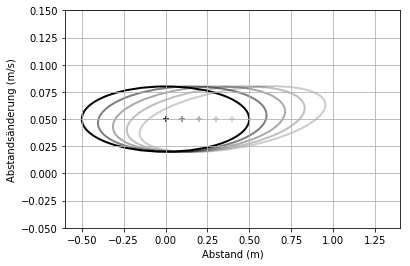

In [9]:
x = np.array([0., 0.05])
P = np.diag([0.25, 0.0009])
dt = 2
F = np.array([[1, dt],[0, 1]])
Q = Q_zero_mean(dim=2, dt=1., var=4e-6)
B = 0
u = 0
fig, ax = plt.subplots()
plot_covariance(x, P, alpha=1, std=[1], axis_equal=False, x_lim=1, y_lim=0.1)
for i in range(4):
    x,P = predict(x, P, F, Q, B, u)
    plot_covariance(x, P, alpha=1/(i+2), std=[1], axis_equal=False, x_lim=1, y_lim=0.1)
    
ax.set_xlabel('Abstand (m)')
ax.set_ylabel('Abstandsänderung (m/s)')

>**Letztlich ist dieses automatische Erscheinen der Korrelation die zentrale Eigenschaft, die diesen zweidimensionalen Kalman-Filter im Vergleich zum eindimensionalen auszeichnet.**  
Wie im Jupyter-Notebook zu den mehrdimensionalen Gaußverteilungen gezeigt, bewirkt diese Korrelation anschließend im Korrekturschritt die wesentlich bessere Schätzung der Zustandsgröße "Abstand" sowie überhaupt eine Schätzung der verdeckten Zustandsgröße "Abstandsänderung".

## Der Korrekturschritt beim zweidimensionalen Kalman-Filter
Der Korrekturschritt ist beim Übergang zum zweidimensionalen Kalman-Filter auch nicht komplizierter als der Vorhersageschritt. Ähnlich wie die Steuermatrix bei der Vorhersage gibt es hier auch einen neuen Parameter, die Beobachtungsmatrix $\mathbf H$.


### Die Beobachtungsmatrix
Bisher gab es zu jedem Zustandswert immer den entsprechenden Messwert. Daher konnte das Residuum $y$ einfach aus der Differenz zwischen dem Vorhersagewert und dem Messwert berechnet werden: $y = z - \bar x$.  
Aber schon beim Beispiel Roboterfahrzeug gibt es für die verdeckte Zustandsgröße Abstandsänderung keinen Messwert.
Außerdem gibt es oft Situationen, bei denen ein Messwert mehrdeutig ist - wie z.B. beim Phasenverfahren des Lidar-Sensors. In diesem Fall kann zwar über den Zustandswert eindeutig auf einen Messwert geschlossen werden. Umgekehrt ist das jedoch nicht möglich.  
Aus diesen Gründen ist es praktikabler, das Residuum nicht im "Zustandsraum" sondern im "Messwertraum" zu berechnen. Sprich man wandelt den Zustandsvektor der Vorhersage $\mathbf x$ zuerst in einen Messwertvektor um. Im Fall einer verdeckten Zustandsgröße fehlt dann im Messwertvektor die entsprechende Komponente, wie gleich gezeigt wird.
**Die Umwandlung vom Zustandsraum in den Messwertraum übernimmt die Beobachtungsmatrix $\mathbf H$.**

$$\mathbf y = \mathbf z - \mathbf{H \bar x}$$  

Entsprechend ändert sich die grafische Darstellung des eindimensionalen Kalmanfilters wie folgt:

<img src="grafikKalman_VorhersKorr_mehrDim.png" width="800">

Welche Elemente muss die Beobachtungsmatrix $\mathbf H$ für das Roboterfahrzeug besitzen?  
Bei der Abstandsänderung handelt es ich um eine verdeckte Zustandsgröße. Daher muss $\mathbf H$ eine solche Gestalt haben, dass  $\mathbf{H\bar x}$ einen eindimensionalen Messwertvektor $\mathbf z$ ergibt.  

$$\mathbf z = \begin{bmatrix}z_0\end{bmatrix}$$

Die Berechnungsformel für das Residuum, welches auch ein eindimensionaler Vektor ist, muss dann folgende Form annehmen:  

$$
\begin{aligned}
\textbf{y} &= \mathbf z - \mathbf{H\bar x}  \\
\begin{bmatrix}y \end{bmatrix} &= \begin{bmatrix}z_0\end{bmatrix} - \begin{bmatrix}?&?\end{bmatrix} \begin{bmatrix}x_0 \\  x_1\end{bmatrix}
\end{aligned}
$$

$\mathbf H$ muss also eine 1x2-Matrix sein. Und für das Residuum $\mathbf y$ muss gelten $\mathbf{y} = [z_0 - \bar x_0]$, denn es hängt nur vom Abstand $x_0$ ab.  

Folglich berechnet sich die Beobachtungsmatrix für das Roboterfahrzeug zu $\mathbf H=\begin{bmatrix}1&0\end{bmatrix}$.  
Nachfolgend wird diese Matrix im Code implementiert.

In [10]:
H = np.array([[1., 0.]])

### Der Messwertvektor und dessen Kovarianzmatrix
Der Messwertvektor beinhaltet die Sensormesswerte des Prozesses, d.h. hier die Messwerte des Abstandssensors des Roboterfahrzeugs. Da wegen der verdeckten Zustandsgröße "Abstandsänderung" nur ein Messwert im Vektor $\mathbf z$ vorliegt, gilt:

$$\mathbf z = \begin{bmatrix}z_0\end{bmatrix}$$

Bei zwei Messwerten würde beispielsweise gelten 

$$\mathbf z = \begin{bmatrix}z_0 \\ z_1\end{bmatrix}$$.

In der Kovarianzmatrix $\mathbf R$ von $\mathbf z$ sind die Messunsicherheiten enthalten. Sie ist eine quadratische Matrix der Form $n \times n$, wobei n die Anzahl der Sensoren bzw. unterschiedlichen Messgrößen ist. Bei mehreren Sensoren sind die Diagonalelemente meist bekannt, da es sich um die Varianzen = Messunsicherheiten der einzelnen Sensoren handelt. Manchmal sind die Messunsicherheiten verschiedener Sensoren jedoch korreliert und/oder nicht wirklich gaußverteilt.  

Im hier betrachteten Beispiel des Roboterfahrzeugs lässt sich die Kovarianzmatrix $\mathbf R$ ganz einfach zu

$$R = \begin{bmatrix}\sigma^2_z\end{bmatrix}$$ 

bestimmen.

Bei zwei unterschiedlichen Messwerten mit einer angenommenen Standardabweichung $\sigma_{z_0} = 0,1 m$ und $\sigma_{z_0} = 0,4 m$ würde sich folgende Matrix ergeben: 
$$R = \begin{bmatrix}0,01&0\\0&0,16\end{bmatrix}$$ 

Im Fall des Roboterfahrzeug mit nur einem Sensor mit $\sigma_{z_0} = 0,1 m$ berechnet sich die Kovarianzmatrix des Messwerts zu $R = \begin{bmatrix}0,01\end{bmatrix}$. 

In [11]:
sigma_z = 0.1
R = np.array([[sigma_z**2]])

Für das Roboterfahrzeug ist der zweidimensionale Kalman-Filter nun komplett initialisiert und alle Parameter sind berechnet. Der Vorhersage-Algorithmus wurde oben schon in Python-Code implementiert. Gleiches muss nur noch mit dem Korrektur-Algorithmus geschehen.
Dies sowie die Simulation des Roboterfahrzeugs sind die Inhalte des nächsten Jupyter-Notebooks. Darin wird dann auch der zweidimensionale Kalman-Filter an verschiedenen Simulationsdaten für das Roboterfahrzeug getestet.

## Bemerkung zu den physikalischen Einheiten
Um die Darstellung der Gleichungen in diesem Jupyter-Notebook möglichst übersichtlich zu halten, wurde in den meisten Fällen auf Einheiten verzichtet. Im Fall des Roboterfahrzeugs müssten korrekter Weise bei den Abständen immer die Einheit "m", bei den Abstandsänderungen "m/s" und bei der Zeit die Einheit "s" aufgeführt werden.  
Grundsätzlich macht es Sinn, die Einheiten weg zu lassen. Im Gegenzug ist jedoch für jede Größe peinlich darauf zu achten, dass immer nur diese eine festgelegte Einheit verwendet wird.